In [1]:
import numpy as np

import os
from datetime import datetime
import glob
from multiprocessing import Pool

from scipy.ndimage import gaussian_filter

from uncertainty import ComputeSidUncertainty

%matplotlib inline

In [2]:
# filter size (Gaissian filter was 5, but weights are smaller for larger distances)
size = 3

# should be 2210 to cover 6 years
n_steps = 2210 

sia_dir = r"D:\SIA_Weddell_Sea"
mesh_dir = f'{sia_dir}/mesh'
unc_dir = f'{sia_dir}/unc'
sid_dir = r"D:\OSI-SAF\Preprocessing_Antarctica"
ifiles = sorted(glob.glob(f'{sid_dir}/*/ice_drift*npz'))
idates = [datetime.strptime(os.path.basename(ifile).split('-')[-1].split('.')[0], '%Y%m%d%H%M%S')
          for ifile in ifiles]
print(f'Found {len(ifiles)} ice drift files from {idates[0]} to {idates[-1]}')

mesh_init_file = r"D:\mesh_weddel_ease_25km_mmg_40_52.npz"
xc = np.load(mesh_init_file)['xc']
yc = np.load(mesh_init_file)['yc']

Found 365 ice drift files from 2015-01-01 12:00:00 to 2015-12-31 12:00:00


# Accumulate and save SID uncertainty
$\sigma_{i} = \sqrt{<\sigma_{i-1}^2> + \sigma_S^2}$

$\sigma_S$ - uncertainty of smoothed SID from CDR

$\sigma_{i-1}$ - uncertainty from previous step

$<>$ - advection operation

$\sigma_S = \frac{\sqrt{\sum_j^N{\sigma_{Oj}}}}{\sqrt{N}}$

$\sigma_{Oj}$ - uncertaimty in neighbour $j$

$N$ - number of neighbours

In [8]:
start_indices = [i for i,j in enumerate(idates) if j.year > 2014 and j.month == 2 and j.day == 15]

In [9]:
csidu = ComputeSidUncertainty(ifiles, idates, mesh_dir, unc_dir, mesh_init_file, n_steps, size, xc, yc)
with Pool(2) as p:
    p.map(csidu.compute_uncertainty, start_indices)

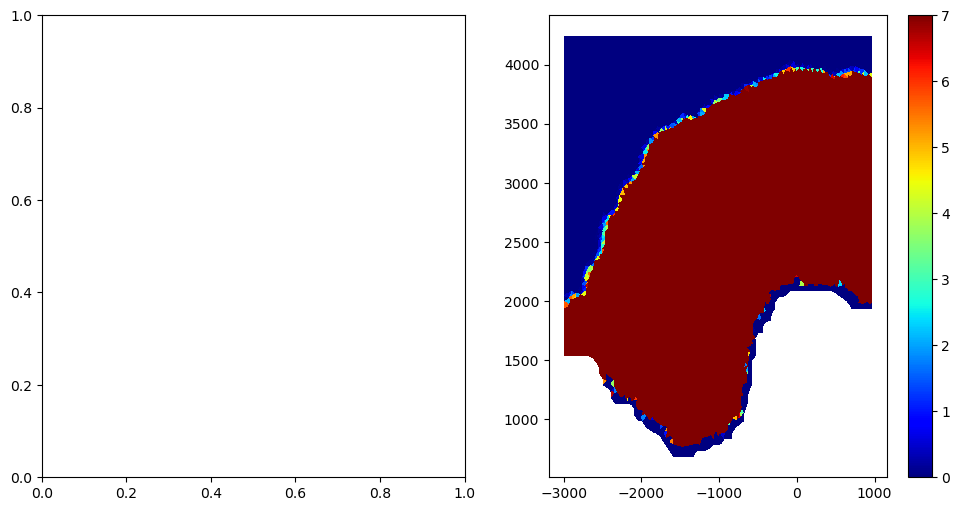

In [13]:
import matplotlib.pyplot as plt
dst_date = '20151231'
#ifile0 = f'data2/Anton/sia/cdr_1991_2023/unc/1991/unc_sic_old/unc_sic_19910905_{dst_date}.npz'
#ifile1 = f'NERSC_arctic25km_sea_ice_age_v2p1/unc/2024/unc_sic_20240905_{dst_date}.npz'
#afile = f'NERSC_arctic25km_sea_ice_age_v2p1/age/{dst_date[:4]}/age_{dst_date}.npz'
ifile1 = f"D:/SIA_Weddell_Sea/unc/2015/unc_sid_20150215_{dst_date}.npz"
afile = f"D:/SIA_Weddell_Sea/age/{dst_date[:4]}/age_{dst_date}.npz"
#ifile1 = f"D:/mesh_output/unc/2015/unc_sic_20150215_{dst_date}.npz"
#afile = f'NERSC_arctic25km_sea_ice_age_v2p1/age/{dst_date[:4]}/age_{dst_date}.npz'
#afile = f"D:/mesh_output/age/{dst_date[:4]}/age_{dst_date}.npz"

with np.load(afile) as f:
    x = f['x']
    y = f['y']
    t = f['t']

#with np.load(ifile0) as f:
#    unc_sic0 = f['unc_sic']

with np.load(ifile1) as f:
    unc_sid1 = f['unc_sid']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#axs[0].tripcolor(x, y, t, unc_sic0, cmap='jet', clim=[0, 7])
plot = axs[1].tripcolor(x, y, t, unc_sid1, cmap='jet', clim=[0, 7])
fig.colorbar(plot, ax=axs[1])
plt.show()
